demandas {1: {6: 0, 7: 1, 8: 2, 9: 3, 10: 2, 11: 2, 12: 3, 13: 3, 14: 5, 15: 2, 16: 2, 17: 0, 18: 1, 19: 2, 20: 3, 21: 3}, 2: {6: 2, 7: 3, 8: 6, 9: 5, 10: 5, 11: 5, 12: 4, 13: 3, 14: 2, 15: 2, 16: 4, 17: 5, 18: 3, 19: 3, 20: 2, 21: 2}, 3: {6: 0, 7: 2, 8: 2, 9: 4, 10: 3, 11: 4, 12: 3, 13: 3, 14: 5, 15: 5, 16: 5, 17: 2, 18: 5, 19: 4, 20: 6, 21: 3}, 4: {6: 1, 7: 1, 8: 1, 9: 2, 10: 2, 11: 2, 12: 1, 13: 3, 14: 3, 15: 5, 16: 5, 17: 4, 18: 4, 19: 4, 20: 5, 21: 2}, 5: {6: 1, 7: 2, 8: 3, 9: 4, 10: 4, 11: 4, 12: 5, 13: 5, 14: 6, 15: 5, 16: 5, 17: 2, 18: 2, 19: 1, 20: 1, 21: 1}, 6: {6: 3, 7: 3, 8: 2, 9: 3, 10: 3, 11: 5, 12: 5, 13: 6, 14: 5, 15: 4, 16: 2, 17: 3, 18: 4, 19: 6, 20: 8, 21: 4}, 7: {6: 4, 7: 5, 8: 4, 9: 3, 10: 4, 11: 5, 12: 5, 13: 2, 14: 0, 15: 1, 16: 1, 17: 3, 18: 3, 19: 4, 20: 3, 21: 4}, 8: {6: 5, 7: 6, 8: 6, 9: 4, 10: 3, 11: 3, 12: 4, 13: 5, 14: 3, 15: 3, 16: 3, 17: 4, 18: 5, 19: 3, 20: 3, 21: 1}, 9: {6: 3, 7: 6, 8: 3, 9: 4, 10: 4, 11: 5, 12: 4, 13: 3, 14: 3, 15: 5, 16: 6, 17: 5, 18

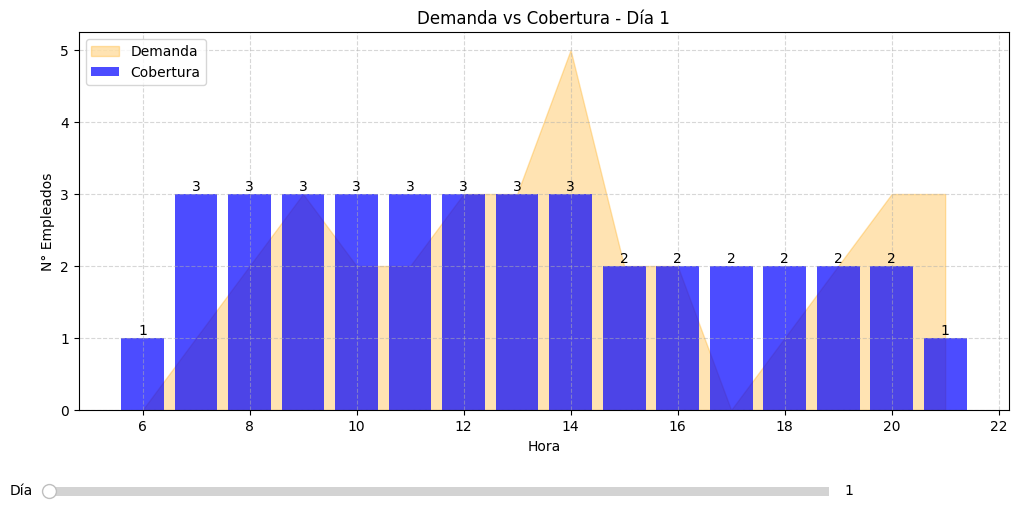

Resultados guardados en resultados.json


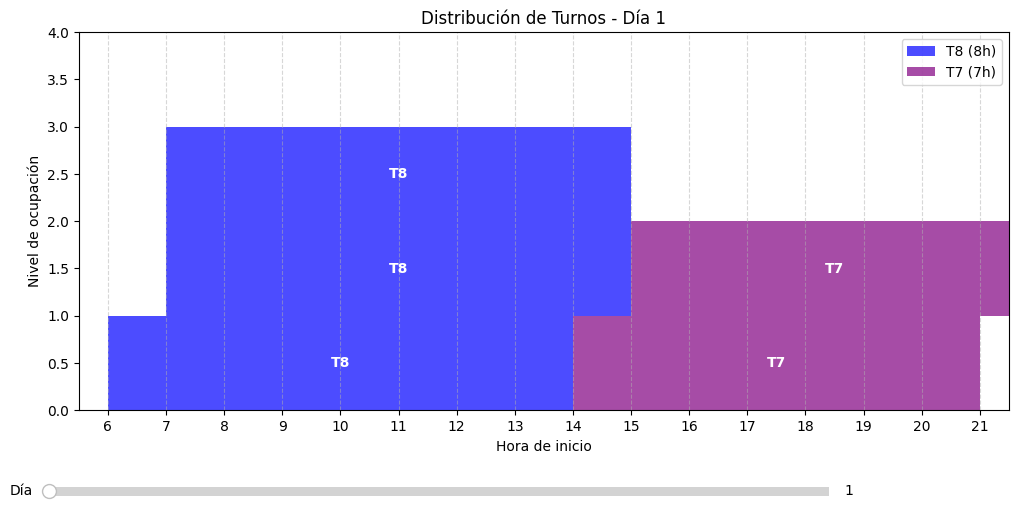

In [3]:
import matplotlib.pyplot as plt
import pulp
import random
from typing import Any
from matplotlib.widgets import Slider
import numpy as np
import json

# Que queremos?
# 1. Llena todos los requisitos de demanda.
# 2. Minimiza el número de empleados.
# 3. Permite cierta superposición entre turnos cuando sea necesario.
# 4. Garantiza una cobertura continua.
# 5. Distribuye la carga de trabajo de manera equitativa.
# 6. Optimiza los costos operativos totales.
# 7. Respeta las restricciones legales de horas de trabajo.
# 8. Mantiene un balance entre turnos cortos y largos.
# 9. Asegura tiempos de descanso adecuados entre turnos.
# 10. Prioriza la estabilidad en la programación.
# 11. Considera picos de demanda en horarios específicos.
# 12. Facilita la rotación de personal entre diferentes turnos.
# 13. Minimiza el tiempo muerto entre turnos consecutivos.
# 14. Optimiza la distribución de habilidades por turno.
# 15. Permite flexibilidad para cambios de última hora.

"""
RESTRICCIONES FINALES DEL MODELO DE OPTIMIZACIÓN
- Debemos minimizar el numero de empleados sub-asignados y sobre-asignados para cada hora.
- La suma de horas con un empleado de cada turno debe ser menor igual a la longitud del turno.
- La suma de horas con un empleado de cada turno debe ser mayor igual a min_horas_continuas del turno.
- No se permiten turnos partidos por más tiempo que tolerancia_continuidad
- Los turnos deben respetar el ratio vs cantidad de otros turnos elegidos.
- Cada turno tiene un limite de asignaciones.
- El numero de empleados asignados a un turno debe ser menor igual al maximo de empleados necesarios para las horas en el turno.
- El numero de empleados asignados a un turno debe ser mayor o igual al minimo de empleados necesarios para las horas en el turno.
- ...?
"""

# Objetivos y restricciones mantenidos como en el código original

def generar_demanda(dias: list[int], horas: list[int], seed: int = 42) -> dict[int, dict[int, float]]:
    """
    Genera datos de demanda artificialmente para cada día y hora, con reproducibilidad.
    :param dias: lista de días (IDs incrementales).
    :param horas: lista de horas.
    :param seed: Semilla para reproducibilidad de datos.
    :return: Diccionario con la demanda por día y hora.
    """
    random.seed(seed)  # Fijar la semilla para reproducibilidad
    demanda_suave: dict[int, dict[int, float]] = {}
    
    for dia in dias:
        demanda_suave[dia] = {}
    
    # Generar demanda inicial
    demanda: dict[int, dict[int, float]] = {}
    for dia in dias:
        demanda[dia] = {hora: float(random.randint(0, 8)) for hora in horas}  # Demanda entre 0 y 8 empleados por hora
    
    # Suaviza con promedio móvil
    for dia in demanda:
        for hora in demanda[dia]:
            if hora == 0:
                demanda_suave[dia][hora] = int(sum(demanda[dia].get(n,0) for n in range(hora, hora + 2)) / 2.0)
            elif hora == max(horas) - 1:
                demanda_suave[dia][hora] = int(sum(demanda[dia].get(n,0) for n in range(hora-1, hora+1)) / 2.0)
            else:
                demanda_suave[dia][hora] = int(sum(demanda[dia].get(n,0) for n in range(hora-1, hora+2)) / 3.0)
    
    return demanda_suave


def cargar_datos(num_weeks: int = 4) -> tuple[dict, dict, dict, dict, dict]:
    """
    Carga los datos iniciales del problema de optimización, agrupando días por semana.
    
    :param num_weeks: Número de semanas a considerar.
    :return: tuple que contiene:
             - demanda: Demanda por día y hora.
             - tipos_turnos: Definición de tipos de turnos.
             - costos: Costos asociados.
             - restricciones: Restricciones del modelo.
             - week_of_day: Mapeo de cada día a su semana correspondiente.
    """
    dias = list(range(1, num_weeks * 7 + 1))  # Días incrementales
    
    # Asignar week_id a cada día (1 para días 1-7, 8 para días 8-14, etc.)
    week_of_day = {dia: ((dia - 1) // 7) * 7 + 1 for dia in dias}
    
    # Horas
    random.seed(42)
    horas = list(range(6, 22))
   
    # Demanda por hora
    demanda = generar_demanda(dias=dias, horas=horas, seed=42)
        
    # Definición de turnos
    tipos_turnos = {
        'T8': {
            'duracion': 8, 
            'limite': 99999,
            "color": 'blue',
            'ratio': {},
            'tolerancia_continuidad': 1,
            'min_horas_continuas': 4,
            'costo_turno_adicional': 1
        },
        'T7': {
            'duracion': 7, 
            'limite': 99999,
            "color": 'purple',
            #'ratio': {'T8': 3},
            'tolerancia_continuidad': 1,
            'min_horas_continuas': 3,
            'costo_turno_adicional': 1
        },
        
        
    }
        
    # Costos
    costos: dict[str, float] = {

        'factor_sub_provisionado': 3,
        'factor_sobre_provisionado': 1,
    }
    
    restricciones: dict[str, float] = {
        # 'cobertura_min': 1,   # Eliminado según instrucción
        # 'cobertura_max': 3,   # Eliminado según instrucción
    }

    return demanda, tipos_turnos, costos, restricciones, week_of_day


def calcular_inicios_turno(
    tipos_turnos: dict[str, dict[str, Any]], 
    demanda: dict[int, dict[int, float]]
) -> dict[int, dict[str, list[int]]]:
    """
    Calcula las horas de inicio posibles para cada tipo de turno por día.
    
    Implementa las siguientes restricciones:
    1. Cobertura continua con tolerancia configurable
    2. Mínimo de horas continuas por bloque
    3. Respeto a los límites de jornada laboral
    4. Optimización de distribución de turnos
    
    Args:
        tipos_turnos: Diccionario con configuración de turnos
        demanda: Diccionario con demanda por día y hora
    
    Returns:
        dict con horas de inicio válidas por día y tipo de turno
    """
    inicios_turno: dict[int, dict[str, list[int]]] = {}
    
    for dia in demanda:
        horas_dia = sorted(list(demanda[dia].keys()))
        hora_inicio_min = min(horas_dia)
        hora_fin_max = max(horas_dia)
        inicios_turno[dia] = {}
        
        for tipo_turno, config in tipos_turnos.items():
            duracion = config['duracion']
            tolerancia_gaps = config.get('tolerancia_continuidad', 0)
            horas_continuas_min = config.get('min_horas_continuas', duracion)
            
            # Calcular ventana válida de inicio considerando restricciones
            if tipo_turno == 'T8':
                ventana_inicio = range(
                    hora_inicio_min,
                    min(19 - duracion + 1, hora_fin_max - duracion + 2)  # Finaliza antes de las 7 pm
                )
            elif tipo_turno == 'T7':
                ventana_inicio = range(
                    max(19 - duracion + 1, hora_inicio_min),  # Inicia para finalizar después de las 7 pm
                    min(22 - duracion + 1, hora_fin_max - duracion + 2)  # Finaliza antes de las 10 pm
                )
            
            inicios_validos = []
            for hora_inicio in ventana_inicio:
                horas_turno = []
                gaps = 0
                bloque_actual = 0
                max_bloque = 0
                
                # Análisis de viabilidad del turno
                for hora in range(hora_inicio, hora_inicio + duracion):
                    if hora in horas_dia:
                        horas_turno.append(hora)
                        bloque_actual += 1
                        max_bloque = max(max_bloque, bloque_actual)
                    else:
                        gaps += 1
                        bloque_actual = 0
                
                # Validación de restricciones
                es_valido = (
                    len(horas_turno) >= horas_continuas_min,  # Cobertura continua mínima
                    gaps <= tolerancia_gaps and             # Gaps permitidos
                    hora_inicio + duracion <= hora_fin_max + 1  # Dentro de límites
                )
                
                if all(es_valido):
                    inicios_validos.append(hora_inicio)
            
            inicios_turno[dia][tipo_turno] = inicios_validos
    
    return inicios_turno


def crear_modelo_optimizacion(
    demanda: dict[int, dict[int, float]],
    tipos_turnos: dict[str, dict[str, Any]],
    inicios_turno: dict[int, dict[str, list[int]]]
) -> tuple[pulp.LpProblem, dict]:
    """
    Crea y configura el modelo de optimización de turnos.
    
    Variables del modelo:
    - x[d,t,i]: Número total de empleados asignados al turno t que inicia en hora i del día d
    - sc[d,h]: Subcobertura en la hora h del día d
    - oc[d,h]: Sobrecobertura en la hora h del día d
    - emp[d,h]: Total empleados trabajando en día d, hora h
    """
    prob = pulp.LpProblem("Optimizacion_Turnos_Personal", pulp.LpMinimize)
    
    vars_modelo: dict = {
        'x': {},    # Asignación total por turno
        'sc': {},   # Subcobertura por hora
        'oc': {},   # Sobrecobertura por hora
        'emp': {},  # Total empleados por hora
    }
    
    # Inicializar variables por día
    for dia in demanda:
        # Variables de asignación total de turnos
        vars_modelo['x'][dia] = {
            turno: {
                inicio: pulp.LpVariable(
                    name=f"x_{dia}_{turno}_{inicio}",
                    lowBound=0,
                    cat=pulp.LpInteger
                )
                for inicio in inicios_turno[dia][turno]
            }
            for turno in tipos_turnos
        }

        # Variables de empleados totales por hora
        vars_modelo['emp'][dia] = {
            hora: pulp.LpVariable(
                name=f"emp_{dia}_{hora}",
                lowBound=0,
                cat=pulp.LpInteger
            )
            for hora in demanda[dia]
        }

        vars_modelo['sc'][dia] = {
            hora: pulp.LpVariable(
                name=f"sc_{dia}_{hora}",
                lowBound=0,
                cat=pulp.LpInteger
            )
            for hora in demanda[dia]
        }

        vars_modelo['oc'][dia] = {
            hora: pulp.LpVariable(
                name=f"oc_{dia}_{hora}",
                lowBound=0,
                cat=pulp.LpInteger
            )
            for hora in demanda[dia]
        }
    
    return prob, vars_modelo


def agregar_restricciones(
    prob: pulp.LpProblem,
    vars_modelo: dict[str, dict],
    costos: dict[str, float],
    restricciones: dict[str, float],
    demanda: dict[int, dict[int, float]],
    tipos_turnos: dict[str, dict[str, Any]],
    inicios_turno: dict[int, dict[str, list[int]]]
) -> None:
    """
    Implementa las restricciones matemáticas del modelo de optimización:
    - Balance de cobertura por hora
    - Ratios entre tipos de turnos
    """
    x = vars_modelo['x']
    sc = vars_modelo['sc']
    oc = vars_modelo['oc']
    emp = vars_modelo['emp']

    # FUNCIÓN OBJETIVO MEJORADA: Minimizar el número total de empleados y minimizar subcobertura y sobrecobertura
    prob += (pulp.lpSum(
            x[d][t][i]*tipos_turnos[t]["costo_turno_adicional"] 
            for d in demanda 
            for t in tipos_turnos 
            for i in inicios_turno[d][t]
        ) +
        costos["factor_sub_provisionado"] * pulp.lpSum(
            sc[d][h]
            for d in demanda 
            for h in demanda[d]
        ) + 
        costos["factor_sobre_provisionado"] * pulp.lpSum(
            oc[d][h] 
            for d in demanda 
            for h in demanda[d]
        )
    ), "Función_objetivo"

    # RESTRICCIONES POR DÍA
    for d in demanda:
        for h in demanda[d]:
            # Balance de cobertura
            prob += (
                emp[d][h] + sc[d][h] - oc[d][h] == demanda[d][h],
                f"balance_total_{d}_{h}"
            )
            prob += (
                emp[d][h] >= 1,
                f"min_empleados_{d}_{h}"
            )
            # Definir emp[d][h] como la suma de empleados cubriendo la hora h
            prob += (
                emp[d][h] == pulp.lpSum(
                    x[d][t][i]
                    for t in tipos_turnos
                    for i in inicios_turno[d][t]
                    if i <= h < i + tipos_turnos[t]['duracion']
                ),
                f"empleados_por_hora_{d}_{h}"
            )
    
    # RESTRICCIONES GLOBALES DE RATIOS
    for t, info in tipos_turnos.items():
        if 'ratio' in info and info['ratio']:
            for related_t, ratio in info['ratio'].items():
                prob += (
                    pulp.lpSum(
                        x[d][t][i] 
                        for d in demanda 
                        for i in inicios_turno[d][t]
                    ) * ratio <=
                    pulp.lpSum(
                        x[d][related_t][i] 
                        for d in demanda 
                        for i in inicios_turno[d][related_t]
                    ),
                    f"ratio_{t}_{related_t}"
                )

        # Restricción de máximo de turnos por día para cada tipo de turno
        if 'max_turnos_dia' in info:
            for d in demanda:
                prob += (
                    pulp.lpSum(
                        x[d][t][i] 
                        for i in inicios_turno[d][t]
                    ) <= info['max_turnos_dia'],
                    f"max_turnos_dia_{t}_{d}"
                )
        # Restricción: Turnos T8 deben finalizar antes de las 19:00
        for d in demanda:
            for i in inicios_turno[d]['T8']:
                prob += (
                    i + tipos_turnos['T8']['duracion'] <= 19,
                    f"T8_finaliza_antes_19_{d}_{i}"
                )

        # Restricción: Turnos T7 deben finalizar después de las 19:00 y antes de las 22:00
        for d in demanda:
            for i in inicios_turno[d]['T7']:
                prob += (
                    19 <= i + tipos_turnos['T7']['duracion'] <= 22,
                    f"T7_finaliza_despues_19_antes_22_{d}_{i}"
                )


def resolver_modelo(prob: pulp.LpProblem) -> int:
    """
    Resuelve el modelo de optimización
    """
    solver = pulp.PULP_CBC_CMD(msg=True)  # Habilitar mensajes del solver
    status = prob.solve(solver)
    return status


def imprimir_resultados(
    prob: pulp.LpProblem,
    vars_modelo: dict[str, dict[int, pulp.LpVariable]],
    demanda: dict[int, dict[int, float]],
    tipos_turnos: dict[str, dict],
    inicios_turno: dict[int, dict[str, list[int]]],
) -> None:
    """
    Imprime los resultados de la optimización
    """
    # Extraer variables del modelo
    x = vars_modelo['x']
    sc = vars_modelo['sc']
    oc = vars_modelo['oc']
    
    print("Estado de la solución:", pulp.LpStatus[prob.status])
    print("Costo total (objetivo):", pulp.value(prob.objective))
    
    # Calcular totales por día
    for d in demanda:
        print(f"\nResultados para día {d}:")
        
        # Calcular total de empleados asignados
        total_empleados = sum(
            x[d][t][i].varValue 
            for t in tipos_turnos 
            for i in inicios_turno[d][t]
            if x[d][t][i].varValue is not None
        )
        print(f"Empleados asignados: {total_empleados}")
        
        # Calcular subcobertura y sobrecobertura
        total_sub = sum(
            sc[d][h].varValue 
            for h in demanda[d] 
            if sc[d][h].varValue is not None
        )
        total_over = sum(
            oc[d][h].varValue 
            for h in demanda[d] 
            if oc[d][h].varValue is not None
        )
        print(f"Faltantes (subcobertura): {total_sub}")
        print(f"Sobrecobertura: {total_over}")
        
        # Imprimir detalles de cada turno asignado
        for t, info in tipos_turnos.items():
            dur = info['duracion']
            for i in inicios_turno[d][t]:
                val = x[d][t][i].varValue
                if val is not None and val > 0:
                    print(f"Turno {t} (dur={dur}h) inicia hora {i} -> "
                          f"termina hora {i + dur - 1}: {int(val)} empleado(s)")


def graficar_demanda_cobertura(demanda, x, tipos_turnos, inicios_turno):
    """
    Genera gráfico de demanda vs cobertura con slider para selección de día
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.subplots_adjust(bottom=0.25)  # Espacio para el slider
    
    dias = sorted(list(demanda.keys()))
    dia_inicial = dias[0]
    
    def update(val):
        ax.clear()
        dia = int(val)
        horas = sorted(list(demanda[dia].keys()))
        cobertura_por_hora = []
        
        # Calcular cobertura por hora
        for h in horas:
            c = sum(
                x[dia][t][i].varValue if x[dia][t][i].varValue else 0
                for t in tipos_turnos
                for i in inicios_turno[dia][t]
                if i <= h < i + tipos_turnos[t]['duracion']
            )
            cobertura_por_hora.append(c)

        # Plot de la demanda
        ax.fill_between(horas, [demanda[dia][h] for h in horas], 
                       color='orange', alpha=0.3, label='Demanda')
        # Plot de la cobertura
        ax.bar(horas, cobertura_por_hora, color='blue', alpha=0.7, 
               label='Cobertura')
        
        # Añadir etiquetas y estilos
        ax.set_xlabel('Hora')
        ax.set_ylabel('N° Empleados')
        ax.set_title(f'Demanda vs Cobertura - Día {dia}')
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend(loc='upper left')
        
        # Añadir valores de cobertura sobre las barras
        for i, v in enumerate(cobertura_por_hora):
            ax.text(horas[i], v, str(int(v)), ha='center', va='bottom')
            
        fig.canvas.draw_idle()

    # Crear slider
    ax_slider = plt.axes([0.1, 0.1, 0.65, 0.03])
    slider = Slider(ax_slider, 'Día', min(dias), max(dias), 
                   valinit=dia_inicial, valstep=1)
    
    slider.on_changed(update)
    update(dia_inicial)
    
    plt.show()


def graficar_distribucion_turnos(demanda, x, tipos_turnos, inicios_turno):
    """
    Genera gráfico de distribución de turnos con slider para selección de día
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.subplots_adjust(bottom=0.25)
    
    dias = sorted(list(demanda.keys()))
    dia_inicial = dias[0]
    
    def update(val):
        ax.clear()
        dia = int(val)
        horas = sorted(list(demanda[dia].keys()))
        
        # Track occupation by hour
        ocupacion = {h: [] for h in horas}
        
        # Ordenar turnos por duración para una mejor visualización
        turnos_ordenados = sorted(tipos_turnos.items(), 
                                key=lambda x: x[1]['duracion'], 
                                reverse=True)
        
        # Procesar cada tipo de turno
        for t, info in turnos_ordenados:
            dur = info['duracion']
            color = info.get('color', 'gray')
            
            # Colocar cada instancia de turno
            for i in inicios_turno[dia][t]:
                val_shift = x[dia][t][i].varValue
                if val_shift is not None and val_shift > 0:
                    for _ in range(int(val_shift)):
                        # Encontrar el nivel de ocupación óptimo
                        min_level = 0
                        while True:
                            horas_turno = range(i, i + dur)
                            niveles_ocupados = set()
                            for h in horas_turno:
                                if h in ocupacion:
                                    niveles_ocupados.update(nivel for nivel, _ in ocupacion[h])
                            
                            if min_level not in niveles_ocupados:
                                break
                            min_level += 1
                        
                        # Dibujar el bloque del turno
                        ax.broken_barh([(i, dur)], (min_level, 1), 
                                     facecolors=color, alpha=0.7)
                        ax.text(i + dur/2, min_level + 0.5, f"{t}",
                               ha='center', va='center', 
                               color='white', fontweight='bold')
                        
                        # Actualizar seguimiento de ocupación
                        for h in horas_turno:
                            if h in ocupacion:
                                ocupacion[h].append((min_level, t))

        # Configurar propiedades del gráfico
        max_level = max(len(niveles) for niveles in ocupacion.values()) if ocupacion else 0
        ax.set_xlabel('Hora de inicio')
        ax.set_ylabel('Nivel de ocupación')
        ax.set_title(f'Distribución de Turnos - Día {dia}')
        ax.set_xlim(min(horas) - 0.5, max(horas) + 0.5)
        ax.set_ylim(0, max_level + 1)
        ax.set_xticks(horas)
        ax.grid(axis='x', linestyle='--', alpha=0.5)
        
        # Añadir leyenda
        legend_elements = [plt.Rectangle((0,0), 1, 1, facecolor=info['color'], 
                          alpha=0.7, label=f"{t} ({info['duracion']}h)")
                          for t, info in tipos_turnos.items()]
        ax.legend(handles=legend_elements, loc='upper right')
        
        fig.canvas.draw_idle()

    # Crear slider
    ax_slider = plt.axes([0.1, 0.1, 0.65, 0.03])
    slider = Slider(ax_slider, 'Día', min(dias), max(dias), 
                   valinit=dia_inicial, valstep=1)
    
    slider.on_changed(update)
    update(dia_inicial)
    
    plt.show()


def analyze_near_feasible_solutions(demanda, vars_modelo, tipos_turnos, inicios_turno, restricciones):
    dias = sorted(list(demanda.keys()))
    horas = sorted(list(demanda[dias[0]].keys()))
    
    violations = []
    for d in dias:
        for h in horas:
            coverage = sum(vars_modelo['x'][d][t][i].varValue 
                         for t in tipos_turnos 
                         for i in inicios_turno[d][t] 
                         if i <= h < i + tipos_turnos[t]['duracion'])
            
            # Ya no hay cobertura_min y cobertura_max
            # Este análisis se puede omitir o ajustar según nuevas restricciones
            
            # Por ejemplo, podrías analizar si coverage == demanda[d][h]
            if coverage < demanda[d][h]:
                gap = demanda[d][h] - coverage
                available_shifts = [(t, i) for t in tipos_turnos 
                                  for i in inicios_turno[d][t] 
                                  if i <= h < i + tipos_turnos[t]['duracion']]
                violations.append({
                    'type': 'Undercoverage',
                    'day': d,
                    'hour': h,
                    'gap': gap,
                    'current': coverage,
                    'required': demanda[d][h],
                    'possible_fixes': len(available_shifts)
                })
            elif coverage > demanda[d][h]:
                excess = coverage - demanda[d][h]
                active_shifts = [(t, i) for t in tipos_turnos 
                               for i in inicios_turno[d][t] 
                               if i <= h < i + tipos_turnos[t]['duracion'] 
                               and vars_modelo['x'][d][t][i].varValue > 0]
                violations.append({
                    'type': 'Overcoverage',
                    'day': d,
                    'hour': h,
                    'gap': excess,
                    'current': coverage,
                    'required': demanda[d][h],
                    'possible_fixes': len(active_shifts)
                })
    
    # Ordenar violaciones por tamaño de gap
    violations.sort(key=lambda x: x['gap'], reverse=True)
    
    print("\nANÁLISIS DE VIOLACIONES DE FACTIBILIDAD")
    print("=" * 80)
    
    if not violations:
        print("¡La solución es factible!")
        return
    
    print(f"Se encontraron {len(violations)} violaciones, mostrando los puntos más cercanos primero:\n")
    
    for v in violations[:10]:  # Mostrar las 10 violaciones más grandes
        print(f"Día {v['day']}, Hora {v['hour']}:")
        print(f"  Tipo: {v['type']}")
        print(f"  Cobertura Actual: {v['current']:.2f}")
        print(f"  Requerido: {v['required']:.2f}")
        print(f"  Gap: {v['gap']:.2f}")
        print(f"  Soluciones Posibles: {v['possible_fixes']} opciones de turno")
        print(f"  Puntuación de Factibilidad: {1 / (1 + v['gap']):.2%}")
        print()
    
    # Estadísticas resumidas
    under_coverage = [v for v in violations if v['type'] == 'Undercoverage']
    over_coverage = [v for v in violations if v['type'] == 'Overcoverage']
    
    print("\nRESUMEN")
    print("=" * 80)
    print(f"Total de violaciones: {len(violations)}")
    print(f"Problemas de subcobertura: {len(under_coverage)}")
    print(f"Problemas de sobrecobertura: {len(over_coverage)}")
    if violations:
        print(f"Tamaño promedio del gap: {sum(v['gap'] for v in violations)/len(violations):.2f}")
        print(f"Mayor gap: {max(v['gap'] for v in violations):.2f}")
        dia_problema = max(set(v['day'] for v in violations), key=lambda d: sum(1 for v in violations if v['day'] == d))
        print(f"Día más problemático: {dia_problema}")
    else:
        print("No hay violaciones en la factibilidad.")


def plot_infeasibility_analysis(demanda, vars_modelo, tipos_turnos, inicios_turno, restricciones):
    fig = plt.figure(figsize=(20, 12))
    gs = plt.GridSpec(3, 2, figure=fig)

    # Panel 1: Coverage vs Requirements
    ax1 = fig.add_subplot(gs[0, :])
    dias = sorted(list(demanda.keys()))
    horas = sorted(list(demanda[dias[0]].keys()))
    
    for dia in dias:
        coverage = [sum(
            vars_modelo['x'][dia][t][i].varValue if vars_modelo['x'][dia][t][i].varValue else 0
            for t in tipos_turnos
            for i in inicios_turno[dia][t]
            if i <= h < i + tipos_turnos[t]['duracion']
        ) for h in horas]
        
        demand = [demanda[dia][h] for h in horas]
        # No hay cobertura_min y cobertura_max
        ax1.plot(horas, coverage, 'b-', label=f'Cobertura Día {dia}')
        # Si se desea, se pueden añadir referencias a la demanda
        ax1.plot(horas, demand, 'r--', label=f'Demanda Día {dia}')
    
    ax1.set_title('Análisis de Cobertura vs Demanda')
    ax1.legend()

    # Panel 2: Shift Distribution Heatmap
    ax2 = fig.add_subplot(gs[1, 0])
    shift_matrix = np.zeros((len(dias), len(horas)))
    for d_idx, dia in enumerate(dias):
        for h_idx, hora in enumerate(horas):
            shift_matrix[d_idx, h_idx] = sum(
                1 for t in tipos_turnos 
                for i in inicios_turno[dia][t] 
                if i <= hora < i + tipos_turnos[t]['duracion']
            )
    
    im = ax2.imshow(shift_matrix, aspect='auto', cmap='Blues')
    ax2.set_title('Densidad de Superposición de Turnos')
    ax2.set_xticks(range(len(horas)))
    ax2.set_xticklabels(horas)
    ax2.set_yticks(range(len(dias)))
    ax2.set_yticklabels(dias)
    plt.colorbar(im, ax=ax2, label='Número de Turnos Superpuestos')

    # Panel 3: Resource Utilization
    ax3 = fig.add_subplot(gs[1, 1])
    for t in tipos_turnos:
        utilization = [sum(
            vars_modelo['x'][d][t][i].varValue if vars_modelo['x'][d][t][i].varValue else 0
            for i in inicios_turno[d][t]
        ) for d in dias]
        ax3.plot(dias, utilization, label=f'Turno {t}')
    
    ax3.set_title('Utilización de Tipos de Turnos')
    ax3.set_xlabel('Día')
    ax3.set_ylabel('Número de Turnos Asignados')
    ax3.legend()

    # Panel 4: Constraint Violation Analysis
    ax4 = fig.add_subplot(gs[2, :])
    violations = []
    for d in dias:
        for h in horas:
            coverage = sum(
                vars_modelo['x'][d][t][i].varValue 
                for t in tipos_turnos 
                for i in inicios_turno[d][t] 
                if i <= h < i + tipos_turnos[t]['duracion']
            )
            required = demanda[d][h]
            
            if coverage < required:
                violations.append(('Subcobertura', d, h, required - coverage))
            elif coverage > required:
                violations.append(('Sobrecobertura', d, h, coverage - required))
    
    if violations:
        types, days, hours, magnitudes = zip(*violations)
        scatter = ax4.scatter(hours, days, c=magnitudes, s=100, cmap='Reds')
        plt.colorbar(scatter, ax=ax4, label='Magnitud de Violación')
        ax4.set_title('Violaciones de Restricciones')
        ax4.set_xlabel('Hora')
        ax4.set_ylabel('Día')
    else:
        ax4.text(0.5, 0.5, 'No hay violaciones de restricciones.', 
                 horizontalalignment='center', verticalalignment='center', 
                 transform=ax4.transAxes, fontsize=15)
        ax4.set_title('Violaciones de Restricciones')
        ax4.axis('off')
    
    plt.tight_layout()
    plt.show()

def guardar_resultados_json(prob, vars_modelo, filepath="resultados.json"):
    """
    Guarda los resultados del modelo en un archivo JSON.
    
    :param prob: El problema de optimización de `pulp`.
    :param vars_modelo: Diccionario con las variables del modelo.
    :param filepath: Ruta del archivo JSON donde se guardarán los resultados.
    """
    resultados = {
        "estado": pulp.LpStatus[prob.status],
        "costo_total": pulp.value(prob.objective),
        "turnos": {},  # Resultados de turnos
        "subcobertura": {},  # Resultados de subcobertura
        "sobrecobertura": {},  # Resultados de sobrecobertura
        "empleados_totales": {}  # Total empleados por hora
    }

    # Extraer los valores de las variables de turnos
    x = vars_modelo['x']
    for d in x:
        resultados["turnos"][d] = {}
        for t in x[d]:
            resultados["turnos"][d][t] = {}
            for i in x[d][t]:
                val = x[d][t][i].varValue
                if val is not None and val > 0:
                    resultados["turnos"][d][t][i] = val

    # Extraer subcobertura y sobrecobertura
    sc = vars_modelo['sc']
    oc = vars_modelo['oc']
    for d in sc:
        resultados["subcobertura"][d] = {h: sc[d][h].varValue for h in sc[d] if sc[d][h].varValue > 0}
        resultados["sobrecobertura"][d] = {h: oc[d][h].varValue for h in oc[d] if oc[d][h].varValue > 0}

    # Total de empleados por hora
    emp = vars_modelo['emp']
    for d in emp:
        resultados["empleados_totales"][d] = {h: emp[d][h].varValue for h in emp[d]}

    # Guardar en un archivo JSON
    with open(filepath, "w") as f:
        json.dump(resultados, f, indent=4)

    print(f"Resultados guardados en {filepath}")
    
def resolver_modelo_debug(prob: pulp.LpProblem) -> int:
    """
    Resuelve el modelo de optimización con mensajes de depuración
    """
    solver = pulp.PULP_CBC_CMD(msg=True)  # Habilitar mensajes del solver
    status = prob.solve(solver)
    
    print(f"Status: {pulp.LpStatus[status]}")
    print(f"Objective: {pulp.value(prob.objective)}")
    
    # Imprimir todas las variables no nulas
    for v in prob.variables():
        if v.varValue > 0:
            print(f"{v.name} = {v.varValue}")
            
    return status


def main():
    """
    Función principal mejorada con nombres explícitos y mejor manejo de variables
    """
    # Carga de datos inicial con agrupación por semanas
    demanda, tipos_turnos, costos, restriciones, week_of_day = cargar_datos(num_weeks=4)
    print("demandas", demanda)
    print("tipos_turnos", tipos_turnos)
    print("costos", costos)
    print("restricciones", restriciones)
    print("week_of_day", week_of_day)
    
    # Cálculo de turnos posibles
    inicios_turno = calcular_inicios_turno(tipos_turnos=tipos_turnos, demanda=demanda)
    
    # Creación del modelo base
    modelo_optimizacion = crear_modelo_optimizacion(
        demanda=demanda,
        tipos_turnos=tipos_turnos,
        inicios_turno=inicios_turno,
    )
    
    # Desempaquetado explícito del modelo
    prob, vars_modelo = modelo_optimizacion
    
    # Agregar restricciones con nombres explícitos
    agregar_restricciones(
        prob=prob,
        vars_modelo=vars_modelo,
        costos=costos,
        restricciones=restriciones,
        demanda=demanda,
        tipos_turnos=tipos_turnos,
        inicios_turno=inicios_turno,
    )
    
    # Resolver el modelo con depuración
    estado_solucion = resolver_modelo_debug(prob=prob)
    
    # Verificar si se encontró solución
    if pulp.LpStatus[estado_solucion] != 'Optimal':
        print(f"No se encontró solución óptima. Estado: {pulp.LpStatus[estado_solucion]}")
        analyze_near_feasible_solutions(demanda, vars_modelo, tipos_turnos, inicios_turno, restriciones)
        plot_infeasibility_analysis(demanda, vars_modelo, tipos_turnos, inicios_turno, restriciones)
        return
    # Imprimir resultados
    imprimir_resultados(
        prob=prob,
        vars_modelo=vars_modelo,
        demanda=demanda,
        tipos_turnos=tipos_turnos,
        inicios_turno=inicios_turno
    )
    
    # Generar visualizaciones
    graficar_demanda_cobertura(
        demanda=demanda,
        x=vars_modelo['x'],
        tipos_turnos=tipos_turnos,
        inicios_turno=inicios_turno
    )
    
    # guardar en un json los resultados
    guardar_resultados_json(prob, vars_modelo, filepath="resultados.json")
    
    graficar_distribucion_turnos(
        x=vars_modelo['x'],
        demanda=demanda,
        tipos_turnos=tipos_turnos,
        inicios_turno=inicios_turno
    )


if __name__ == "__main__":
    main()



In [2]:
import pulp
import json
from collections import defaultdict
from typing import Dict, List

# Configuración de turnos con ventanas ampliadas
TIPOS_TURNOS = {
    'Diurna': {
        'duracion': 8,
        'inicio': range(6, 13),  # 6:00 AM - 12:00 PM
        'costo': 1.2,
        'max_semanal': 5
    },
    'Mixta': {
        'duracion': 7,
        'inicio': range(11, 17),  # 11:00 AM - 4:00 PM
        'costo': 1.5,
        'max_semanal': 5
    }
}

DIAS_SEMANA = 7
HORAS_MAX_SEMANALES = 48
EMPLEADOS_MAX = 15  # Empezar con más empleados y optimizar

def cargar_y_procesar_datos(json_data: Dict) -> tuple:
    """Carga y normaliza los datos de demanda"""
    demanda = defaultdict(dict)
    fechas = []
    
    for fecha, datos in json_data['28']['predicciones'].items():
        fechas.append(fecha)
        dia_num = len(fechas)
        for entrada in datos['datos']:
            hora = entrada['hora']
            demanda[dia_num][hora] = max(1, int(round(entrada['personal_necesario'])))
    
    # Normalizar horas faltantes
    todas_horas = set()
    for dia in demanda.values():
        todas_horas.update(dia.keys())
    
    for dia in demanda:
        for h in todas_horas:
            if h not in demanda[dia]:
                demanda[dia][h] = 0
                
    return demanda, fechas

def crear_modelo_factible(demanda: Dict, num_dias: int) -> pulp.LpProblem:
    """Crea modelo con restricciones relajadas"""
    prob = pulp.LpProblem("Optimizacion_Horarios_Flexible", pulp.LpMinimize)
    
    # Variables principales
    turnos = pulp.LpVariable.dicts(
        'Turno',
        [(e, dia, tipo, inicio) 
         for e in range(1, EMPLEADOS_MAX + 1)
         for dia in range(1, num_dias + 1)
         for tipo, config in TIPOS_TURNOS.items()
         for inicio in config['inicio']],
        cat='Binary'
    )
    
    # Variables de relajación
    sub = pulp.LpVariable.dicts(
        'Subcobertura',
        [(dia, hora) for dia in demanda for hora in demanda[dia]],
        lowBound=0,
        cat='Integer'
    )
    
    sobre = pulp.LpVariable.dicts(
        'Sobrecobertura',
        [(dia, hora) for dia in demanda for hora in demanda[dia]],
        lowBound=0,
        cat='Integer'
    )
    
    # Función objetivo con penalizaciones
    prob += (
        pulp.lpSum(
            turnos[e, dia, tipo, inicio] * TIPOS_TURNOS[tipo]['costo']
            for e in range(1, EMPLEADOS_MAX + 1)
            for dia in range(1, num_dias + 1)
            for tipo, config in TIPOS_TURNOS.items()
            for inicio in config['inicio']
        ) +
        pulp.lpSum(sub[dia, hora] * 10 for dia, hora in sub) +  # Alta penalización por subcobertura
        pulp.lpSum(sobre[dia, hora] * 2 for dia, hora in sobre)
    )
    
    # Restricciones de cobertura con relajación
    for dia in demanda:
        for hora, necesarios in demanda[dia].items():
            prob += (
                pulp.lpSum(
                    turnos[e, dia, tipo, inicio]
                    for e in range(1, EMPLEADOS_MAX + 1)
                    for tipo, config in TIPOS_TURNOS.items()
                    for inicio in config['inicio']
                    if inicio <= hora < inicio + config['duracion']
                ) + sub[dia, hora] - sobre[dia, hora] >= necesarios,
                f"Cobertura_D{dia}_H{hora}"
            )
    
    # Restricciones para empleados
    for e in range(1, EMPLEADOS_MAX + 1):
        # Máximo 6 días trabajados
        prob += (
            pulp.lpSum(
                turnos[e, dia, tipo, inicio]
                for dia in range(1, num_dias + 1)
                for tipo, config in TIPOS_TURNOS.items()
                for inicio in config['inicio']
            ) <= 6 * max(t['max_semanal'] for t in TIPOS_TURNOS.values()),
            f"Max_Dias_Empleado{e}"
        )
        
        # Balance de tipos de turnos
        for tipo, config in TIPOS_TURNOS.items():
            prob += (
                pulp.lpSum(
                    turnos[e, dia, tipo, inicio]
                    for dia in range(1, num_dias + 1)
                    for inicio in config['inicio']
                ) <= config['max_semanal'],
                f"Max_{tipo}_Empleado{e}"
            )
    
    return prob, turnos, sub, sobre

def procesar_resultados(turnos, sub, sobre, fechas) -> Dict:
    """Genera estructura de resultados detallada"""
    horarios = defaultdict(list)
    empleados_activos = set()
    
    # Procesar turnos asignados
    for var in turnos:
        e, dia, tipo, inicio = var
        if turnos[var].value() == 1:
            empleados_activos.add(e)
            horarios[e].append({
                'fecha': fechas[dia-1],
                'turno': tipo,
                'inicio': f"{inicio:02d}:00",
                'fin': f"{inicio + TIPOS_TURNOS[tipo]['duracion']:02d}:00"
            })
    
    # Procesar coberturas
    cobertura = defaultdict(dict)
    for (dia, hora), var in sub.items():
        cobertura[fechas[dia-1]][hora] = {
            'requerido': demanda[dia][hora],
            'asignado': var.value() + sobre[dia, hora].value(),
            'subcobertura': var.value(),
            'sobrecobertura': sobre[dia, hora].value()
        }
    
    return {
        'horarios': dict(horarios),
        'cobertura': cobertura,
        'total_empleados': len(empleados_activos),
        'empleados_activos': sorted(empleados_activos)
    }

def main():
    # Cargar datos
    with open('datos.json') as f:
        json_data = json.load(json.load)
    
    demanda, fechas = cargar_y_procesar_datos(json_data)
    num_dias = len(fechas)
    
    # Crear y resolver modelo
    prob, turnos, sub, sobre = crear_modelo_factible(demanda, num_dias)
    prob.solve(pulp.PULP_CBC_CMD(msg=True, timeLimit=60))
    
    if pulp.LpStatus[prob.status] == 'Optimal':
        resultados = procesar_resultados(turnos, sub, sobre, fechas)
        
        with open('horarios_optimizados.json', 'w') as f:
            json.dump(resultados, f, indent=2)
        
        print(f"\nSolución óptima encontrada con {resultados['total_empleados']} empleados")
        print("Ejemplo de horario para el Empleado 1:")
        print(json.dumps(resultados['horarios'][1], indent=2))
        
        # Estadísticas de cobertura
        total_sub = sum(v['subcobertura'] for dia in resultados['cobertura'].values() for v in dia.values())
        total_sobre = sum(v['sobrecobertura'] for dia in resultados['cobertura'].values() for v in dia.values())
        print(f"\nSubcobertura total: {total_sub}")
        print(f"Sobrecobertura total: {total_sobre}")
    else:
        print("\n¡Solución no encontrada! Recomendaciones:")
        print("1. Aumentar EMPLEADOS_MAX en el código")
        print("2. Ampliar rangos de inicio de turnos")
        print("3. Reducir requisitos de personal_necesario en un 10-15%")

if __name__ == "__main__":
    main()

AttributeError: 'function' object has no attribute 'read'